# Test Analyser

Read in the results data and analyse.

We assume that the 1PL model is used.

$$
Pr(X=1) = \frac{exp(\theta-b)}{1 + exp(\theta-b)}
$$

## Data Ingest

For this analysis we need the `results.csv` file from the `data` folder.

In [1]:
library(tidyverse)
library(ltm)

dfRaw <- read_csv("data/results.csv")

dfTest <- dfRaw %>%
  dplyr::select(-systemname)

numItems <- ncol(dfTest)
numCandidates <- nrow(dfTest)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: msm

Loading required package: polycor


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  systemname = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [2]:
# show the top of the dataset...
head(dfRaw[1:5])

systemname,A1L_7616_01#6789,A1L_20679_02#6790,A1L_5480_03#6791,A2L_5483_04#6792
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DT0001,0,0,0,0
DT0002,0,0,0,0
DT0003,0,1,0,1
DT0004,0,0,0,0
DT0005,0,0,0,0
DT0006,1,1,1,1


## Descriptive Stats
Output the frequencies of number correct (NC) scores...

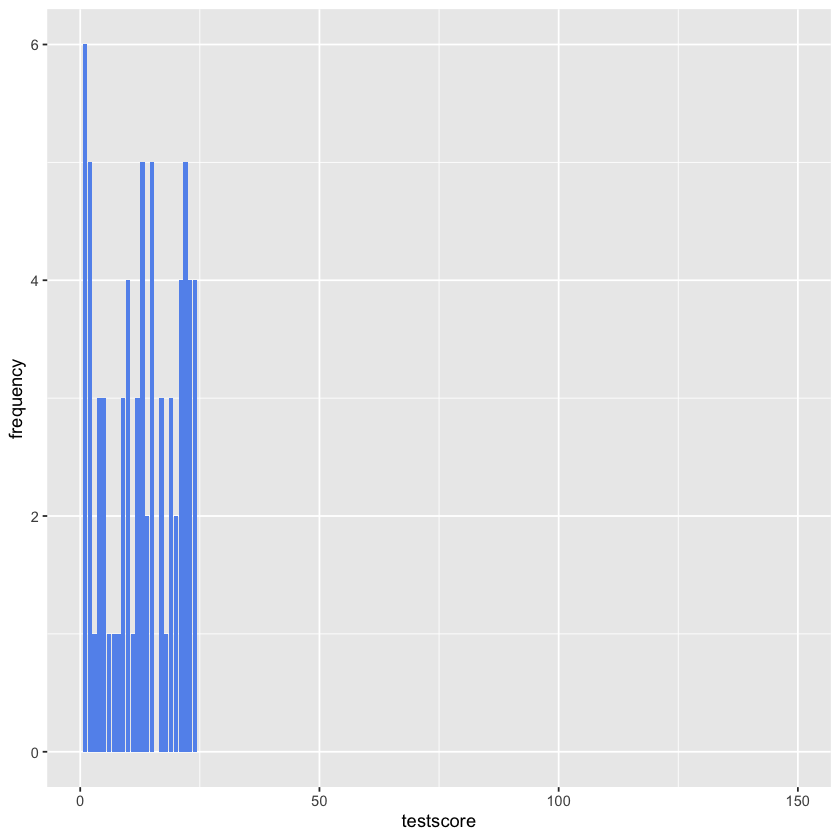

In [3]:
summary <- ltm::descript(dfTest, chi.squared = FALSE)
freq_df <- enframe(summary$items[1:length(summary$items)],
                   name = "testscore", value = "frequency")

ggplot(data = freq_df) +
  geom_bar(mapping = aes(x = testscore, y = frequency),
           stat = "identity", fill = "cornflowerblue")

## Rasch Modelling
We can apply the Rasch model to summarise the item difficulties.

In [4]:
raschmodel <- ltm::rasch(dfTest, constraint = cbind(length(dfTest) + 1, 1),
                         IRT.param = TRUE, start.val = "random")
rasch_summary <- summary(raschmodel)

ERROR: Error in ltm::rasch(dfTest, constraint = cbind(length(dfTest) + 1, 1), : 'data' contain more that 2 distinct values for item(s): 113, 114, 115, 116, 117, 118, 124, 125


### Outputting Difficulties
From this we can then derive difficulties for items that have no already been assigned a difficulty parameter.

In [5]:
df_difficulties <- data.frame(
  head(rasch_summary$coefficients, -1)
)
df_difficulties$a <- rasch_summary$coefficients['Dscrmn', 1]
df_difficulties$uiid <- rownames(df_difficulties)

In [6]:
(df_difficulties)

,value,std.err,z.vals,a,uiid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Dffclt.A1L_7616_01#6789,0.4484814,0.1358226,3.301964,1,Dffclt.A1L_7616_01#6789
Dffclt.A1L_20679_02#6790,0.4656156,0.1358904,3.426406,1,Dffclt.A1L_20679_02#6790
Dffclt.A1L_5480_03#6791,0.6023225,0.1365262,4.411773,1,Dffclt.A1L_5480_03#6791
Dffclt.A2L_5483_04#6792,0.8977626,0.1385153,6.481326,1,Dffclt.A2L_5483_04#6792
Dffclt.A2L_24442_05#6793,0.5683279,0.1363520,4.168094,1,Dffclt.A2L_24442_05#6793
Dffclt.A2L_7620_06#6794,0.6703411,0.1369076,4.896302,1,Dffclt.A2L_7620_06#6794
Dffclt.A2L_7627_07#6795,0.9505997,0.1389653,6.840556,1,Dffclt.A2L_7627_07#6795
Dffclt.B1L_20849_08#6796,1.1318424,0.1407393,8.042119,1,Dffclt.B1L_20849_08#6796
Dffclt.B1L_4287_09#6797,1.0947383,0.1403465,7.800253,1,Dffclt.B1L_4287_09#6797


## Characteristic Curves and Information Functions
It's also possible to display characteristic curves and information functions. We need a couple of helper functions to do this.

In [7]:
# return a data frame with true score summaries
# that can then be plotted
trueScoreSummary <- function(plotData) {
  data.frame(theta = as.vector(plotData[,1]),
             trueScore = as.vector(rowSums(plotData[,-1])))
}

# return a data frame with information coefficient summaries
# that can then be plotted
informationCoefficients <- function(plotData) {
  data.frame(theta = as.vector(plotData[,1]),
             information = as.vector(rowSums(plotData[,-1])))
}

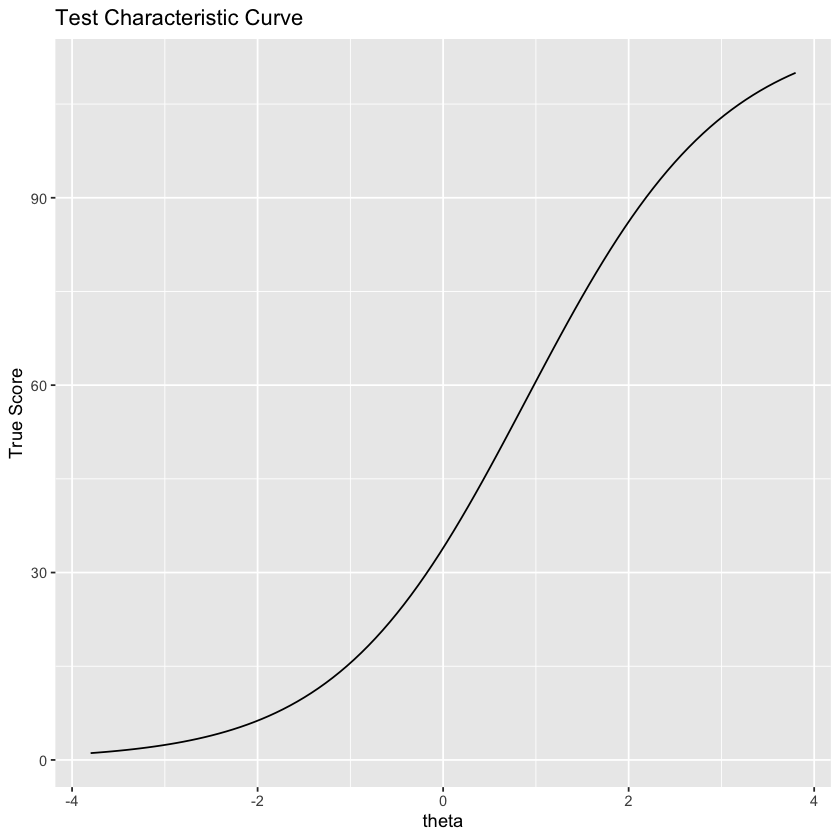

In [8]:
tcc <- trueScoreSummary(plot(raschmodel, type = "ICC", plot = FALSE))

ggplot(tcc, aes(x=theta, y=trueScore)) +
  geom_line() +
  labs(title="Test Characteristic Curve", x="theta", y="True Score")

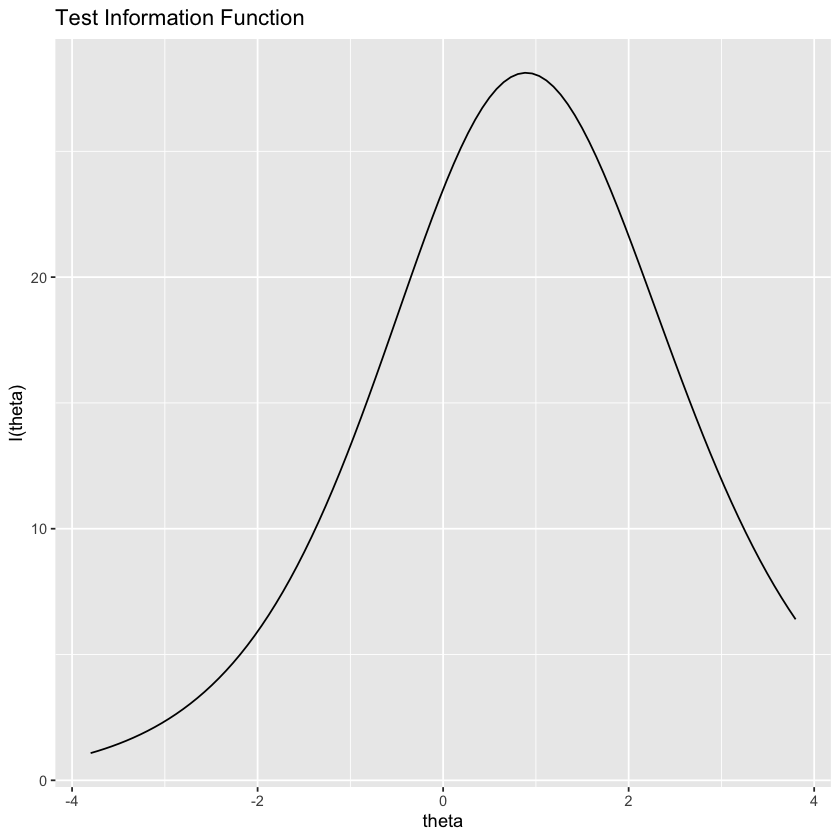

In [9]:
iif <- informationCoefficients(plot(raschmodel, type = "IIC", plot = FALSE))

ggplot(iif, aes(x=theta, y=information)) +
  geom_line() +
  labs(title="Test Information Function", x="theta", y="I(theta)")

In [4]:
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          0.2                         
year           2020                        
month          06                          
day            22                          
svn rev        78730                       
language       R                           
version.string R version 4.0.2 (2020-06-22)
nickname       Taking Off Again            

In [5]:
sessioninfo()

ERROR: Error in sessioninfo(): could not find function "sessioninfo"


In [6]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_GB.UTF-8/en_GB.UTF-8/en_GB.UTF-8/C/en_GB.UTF-8/en_GB.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ltm_1.1-1       polycor_0.7-10  msm_1.6.8       MASS_7.3-53    
 [5] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4    
 [9] readr_1.4.0     tidyr_1.1.3     tibble_3.1.2    ggplot2_3.3.5  
[13] tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7          lattice_0.20-41     lubridate_1.7.10   
 [4] mvtnorm_1.1-2       getPass_0.2-2       assertthat_0.2.1   
 [7] digest_0.6.29       utf8_1.2.2          IRdisplay_1.0      
[10] R6_2.5.0            cellranger_1.1.0